In [75]:
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, '../visualize/')
sys.path.insert(0, '../models/')
sys.path.insert(0, '../features/')

from tcors_functions import *
from build_features import *
from counterprop import *
from linear_regression import *
from visualize import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

random_state = 42

bin_step = 0.1

Prepare Data

In [60]:
build_features(step = bin_step)

In [61]:
df = load_features('model_features.pkl')
df.head()

,screen_id,week,project,site,dose,screen_sex,screen_age,carmine_nicotine,prp_change,prp_change_bin,prp_change_bin_label
37,J-A003,week12,project 1,uvm,15.8,Female,32,16.7,0.487500,"(0.4, 0.5]",4
50,J-A004,week12,project 1,uvm,0.4,Female,38,15.9,0.725225,"(0.7, 0.8]",7
76,J-A007,week12,project 1,uvm,15.8,Female,44,16.2,0.971223,"(0.9, 1.0]",9
89,J-A010,week12,project 1,uvm,15.8,Female,28,15.8,0.895522,"(0.8, 0.9]",8
117,J-A015,week12,project 1,uvm,15.8,Female,25,16.9,1.315152,"(1.3, 1.4]",13


In [62]:
df.dtypes

screen_id                 object
week                      object
project                   object
site                      object
dose                     float64
screen_sex                object
screen_age                 int64
carmine_nicotine         float64
prp_change               float64
prp_change_bin          category
prp_change_bin_label        int8
dtype: object

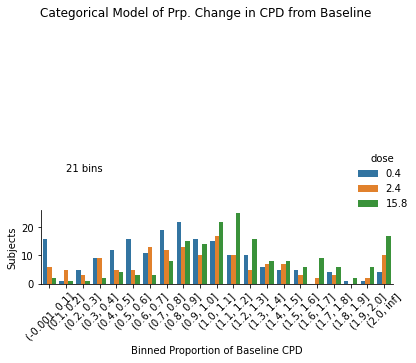

In [63]:
 plot_bins(df)
 plt.tight_layout()
plt.savefig("../../reports/figures/prp_change.png", dpi = 300)

In [64]:

cat_targets = ['prp_change_bin_label']
num_targets = ['prp_change']
# cat_predictors = ['project', 'site', 'dose', 'screen_sex']
num_predictors = ['screen_age', 'dose', 'project_num', 'sex_num', 'site_num', 'carmine_nicotine']
num_predictors_withoutnic = num_predictors[:]
num_predictors_withoutnic.remove('carmine_nicotine')

  # create numeric versions of categorical variables
df['project_num'] = df['project'].astype('category').cat.codes
df['site_num'] = df['site'].astype('category').cat.codes
df['sex_num'] = df['screen_sex'].astype('category').cat.codes

def preprocessing(df, num_predictors, random_state):
  
    X = df[num_predictors]
    y = df[cat_targets + num_targets]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    scaler = MinMaxScaler()
    scaler.fit(X_train[num_predictors])

    X_train[num_predictors] = scaler.transform(X_train[num_predictors])
    X_test[num_predictors] = scaler.transform(X_test[num_predictors])

    X_train_without_nic = X_train.copy()
    X_test_without_nic = X_test.copy()

    X_train_without_nic.drop(['carmine_nicotine'], axis=1, inplace=True)
    X_test_without_nic.drop(['carmine_nicotine'], axis=1, inplace=True)

    return X_train, X_test, X_train_without_nic, X_test_without_nic, y_train, y_test

X_train, X_test, X_train_without_nic, X_test_without_nic, y_train, y_test = preprocessing(
  df, num_predictors, random_state
  )

   

In [65]:
X_test

,screen_age,dose,project_num,sex_num,site_num,carmine_nicotine
5706,0.32,1.00000,1.0,0.0,1.0,0.689441
8791,0.24,1.00000,0.5,0.0,0.5,0.236025
7935,0.18,1.00000,0.0,0.0,0.5,0.347826
3008,0.20,1.00000,0.5,1.0,1.0,0.254658
8817,0.60,0.12987,0.5,1.0,0.5,0.354037
...,...,...,...,...,...,...
7295,0.32,1.00000,0.0,0.0,0.5,0.155280
3277,0.48,0.00000,0.5,0.0,1.0,0.161491
5233,0.30,1.00000,1.0,1.0,1.0,0.347826
8924,0.36,1.00000,0.5,0.0,0.5,0.354037


## Linear Regression

In [66]:
without_nic = fit_linear(
    X_train_without_nic,
    X_test_without_nic,
    y_train[['prp_change']],
    y_test[['prp_change']],
    bin_step = bin_step,
    random_state=random_state
)

with_nic = fit_linear(
    X_train,
    X_test,
    y_train[['prp_change']],
    y_test[['prp_change']],
    bin_step = bin_step,
    random_state=random_state
)

Performance when treated as a regression

In [67]:
wo_nic_avg = without_nic.avg_scores
wo_nic_avg['label'] = 'without_nic'

w_nic_avg = with_nic.avg_scores
w_nic_avg['label'] = 'with_nic'

lm_r2 = pd.concat([wo_nic_avg, w_nic_avg])
lm_r2['model'] = 'linear_model'

lm_r2

,mean_cv_r2,sd_cv_r2,test_r2,label,model
1,0.083358,0.075021,0.139511,without_nic,linear_model
1,0.074846,0.075885,0.092326,with_nic,linear_model


Performance when treated as a classifier

In [68]:
lm_f1 = pd.DataFrame(
    {
        "f1" : [without_nic.clf_mets, with_nic.clf_mets],
        "label" : ["without_nic", "with_nic"],
        "model" : ['linear_model*', 'linear_model*']
    }
)
lm_f1


,f1,label,model
0,0.106796,without_nic,linear_model*
1,0.116505,with_nic,linear_model*


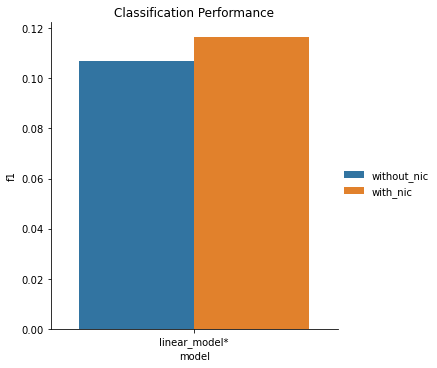

In [69]:
clf_plt(lm_f1)

## Counter-Propagation  

In [70]:
# np.save(file = "../../data/processed/X_train.npy", arr= X_train_without_nic)
# np.save(file = "../../data/processed/y_train.npy", arr = y_train['prp_change_bin_label'])

y_train_onehot = onehot_output(y_train['prp_change_bin_label'])
y_train['prp_change_bin_label'].unique()

array([17,  6,  9,  3, 20, 11,  7, 14, 10,  8,  5, 16,  1,  0,  2, 12, 19,
       13, 15,  4, 18], dtype=int8)

In [71]:
y_train_onehot = onehot_output(y_train['prp_change_bin_label'])
mod = train_model(
    np.array(X_train_without_nic), 
    y_train_onehot, 
    n_hidden = len(X_train), 
    epochs=25)

[[ 0.38754938  0.73214056  0.40741586 ...  0.75565309  0.60021494
   0.37172582]
 [ 0.91199553  0.12803329  0.11422667 ...  0.05246711  1.01022854
   0.22973165]
 [ 1.18330754  0.88677916  0.50649859 ...  0.99177855  0.17131463
   0.55781876]
 [-0.0281525   1.02089193 -0.02552695 ...  1.10161509 -0.17077489
   0.00154151]
 [ 1.11186428  0.08737986  0.9933202  ...  0.05103984  0.55599857
   1.1061841 ]]


In [81]:
f1_score(y_train['prp_change_bin_label'], np.argmax(mod.outputs, axis=1), average = 'micro')



0.15853658536585366

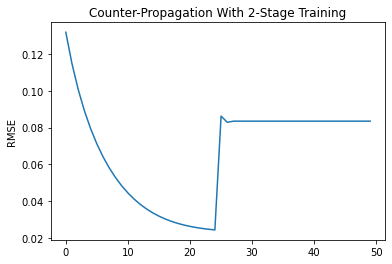

In [54]:
plt.plot(mod.rmse_values)
plt.ylabel("RMSE")
plt.title("Counter-Propagation With 2-Stage Training")
plt.savefig("../../reports/figures/counterprop_train.png", dpi = 300)
plt.show()
